# load data from kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"christopherkeibel","key":"3cfad0619d88b713dbe51f53991891d9"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# downloading dataset from kaggle
!kaggle competitions download -c dogs-vs-cats

 98% 793M/812M [00:04<00:00, 196MB/s]
100% 812M/812M [00:04<00:00, 184MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip
!ls

dogs-vs-cats.zip  sample_data		test1.zip  train.zip
kaggle.json	  sampleSubmission.csv	train


# split data into different datasets

In [5]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("dogs_vs_cats_small")

def make_subset(subset_name, start, end):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)

        fnames = [f"{category}.{i}.jpg" for i in range(start, end)]

        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

In [6]:
make_subset("train", start=0, end=1_000)
make_subset("validation", start=1_000, end=1_500)
make_subset("test", start=1_500, end=2_500)

In [8]:
!ls dogs_vs_cats_small

test  train  validation


# create tensorflow datasets

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# create data augmentation pipeline

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation_pipeline = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.2)
])

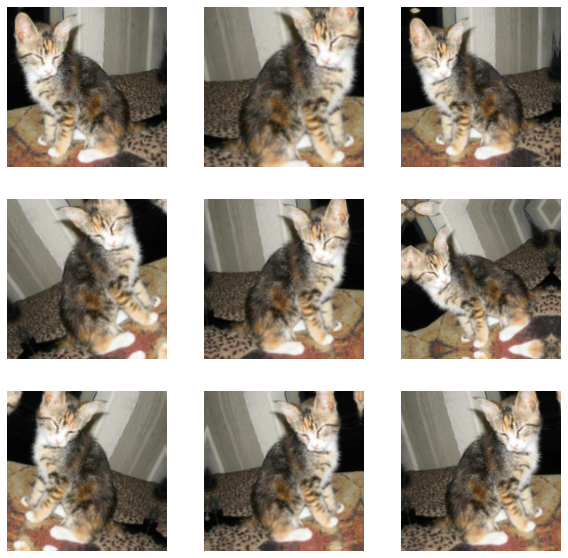

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation_pipeline(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# build model and fit it

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Rescaling, Dense, Flatten, Dropout

inputs = Input(shape=(180, 180, 3))
x = data_augmentation_pipeline(inputs) # AUGMENTATION PIPELINE
x = Rescaling(1./255)(x)
x = Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(256, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(256, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
outputs= Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                             

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [18]:
res = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 [==============================] - 18s 82ms/step - loss: 0.7082 - accuracy: 0.4905 - val_loss: 0.6967 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 5s 82ms/step - loss: 0.6949 - accuracy: 0.4940 - val_loss: 0.6882 - val_accuracy: 0.5270
Epoch 3/100
63/63 [==============================] - 5s 71ms/step - loss: 0.7161 - accuracy: 0.5415 - val_loss: 0.6801 - val_accuracy: 0.6100
Epoch 4/100
63/63 [==============================] - 5s 70ms/step - loss: 0.7013 - accuracy: 0.5630 - val_loss: 0.6751 - val_accuracy: 0.5790
Epoch 5/100
63/63 [==============================] - 5s 72ms/step - loss: 0.6735 - accuracy: 0.5990 - val_loss: 0.6608 - val_accuracy: 0.5820
Epoch 6/100
63/63 [==============================] - 5s 70ms/step - loss: 0.6546 - accuracy: 0.6310 - val_loss: 0.6831 - val_accuracy: 0.5610
Epoch 7/100
63/63 [==============================] - 5s 70ms/step - loss: 0.6393 - accuracy: 0.6465 - val_loss: 0.6545 - val_accuracy: 0.6320
Epoch

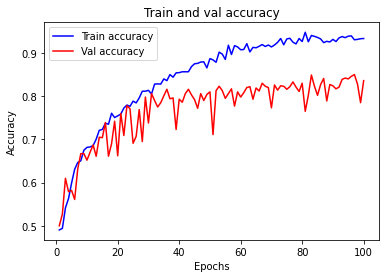

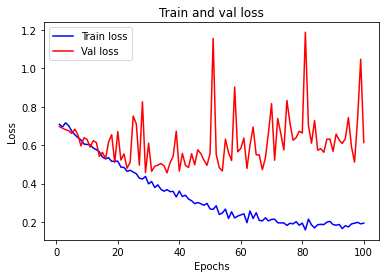

In [20]:
loss = res.history["loss"]
acc = res.history["accuracy"]
val_loss = res.history["val_loss"]
val_acc = res.history["val_accuracy"]
x_range = range(1, len(loss) +1)

plt.plot(x_range, acc, "b", label="Train accuracy")
plt.plot(x_range, val_acc, "r", label="Val accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and val accuracy")
plt.legend()
plt.figure()
plt.plot(x_range, loss, "b", label="Train loss")
plt.plot(x_range, val_loss, "r", label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and val loss")
plt.legend()
plt.show()

In [21]:
from tensorflow.keras.models import load_model

test_model = load_model("convnet_from_scratch.keras")
test_loss, test_accuracy = test_model.evaluate(test_dataset)

print(f"test accuracy: {test_accuracy}")

63/63 [==============================] - 3s 36ms/step - loss: 0.4640 - accuracy: 0.7935
test accuracy: 0.7935000061988831
